In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cancer-data/Cancer_Data.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF, TruncatedSVD
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.model_selection import GridSearchCV


warnings.filterwarnings("ignore")

# Week 5: Unsupervised Learning Project: Cancer Diagnosis Classification

# Project Introduction

For our final project, I've decided to focus on cancer diagnosis classification. I've acquired my data from Kaggle (https://www.kaggle.com/datasets/erdemtaha/cancer-data/data). This dataset contains information about cancer type ("benign" or "malignant") along with its description, such as smoothness, concavity, area, texture, etc. In this project, we'll explore unsupervised methods such as KNN, SVD, and NMF to see how well they are at predict/making cancer type diagnosis. Additionally, we'll also explore some supervised methods and compare them.

# Data Cleaning

In [3]:
# load the cancer diagnosis data
data = pd.read_csv('/kaggle/input/cancer-data/Cancer_Data.csv')

In [4]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [5]:
# From looking at the data, we can see that the last column is empty and contains no values, we'll drop it
data.drop(columns=['Unnamed: 32'], inplace=True)
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [7]:
print(data.isnull().sum())

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


**Analysis:**
1. Most of the cancer diagnosis type descriptions are all numeric, which makes it easier to turn them into matrices for model fitting later.
2. There are null-values or missing values in the columns.
3. There was an empty column at the end of the dataset and has been removed from the dataset.

# Data Analysis

# Cancer Diagnosis Type Frequency

In [8]:
data['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

Here, we will plot the frequency of each cancer diagnosis type. This will show us whether the data is skewed or more favored towards one type or another.

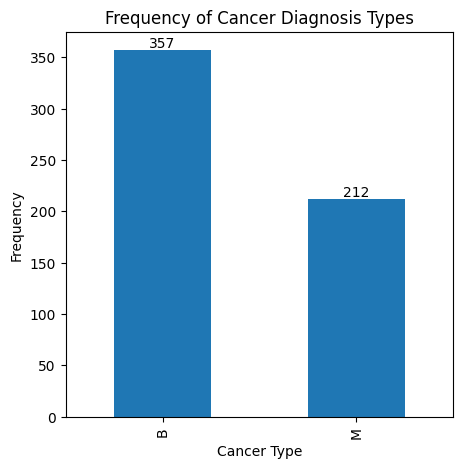

In [9]:
plt.figure(figsize=(5, 5))
data['diagnosis'].value_counts().plot(kind='bar')
plt.title('Frequency of Cancer Diagnosis Types', fontsize=12)
plt.xlabel('Cancer Type', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
for index, value in enumerate(data['diagnosis'].value_counts()):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)
plt.show()

**Analysis:**
In our dataset, we can see that the data contains more cancer diagnosis that are benign (~70% more). By understanding the descrepency between the two, it'll help us understand a bit better when we try to analyze the results later after we've done our predictions.

# Feature Distribution on Tumor Diagnosis Type

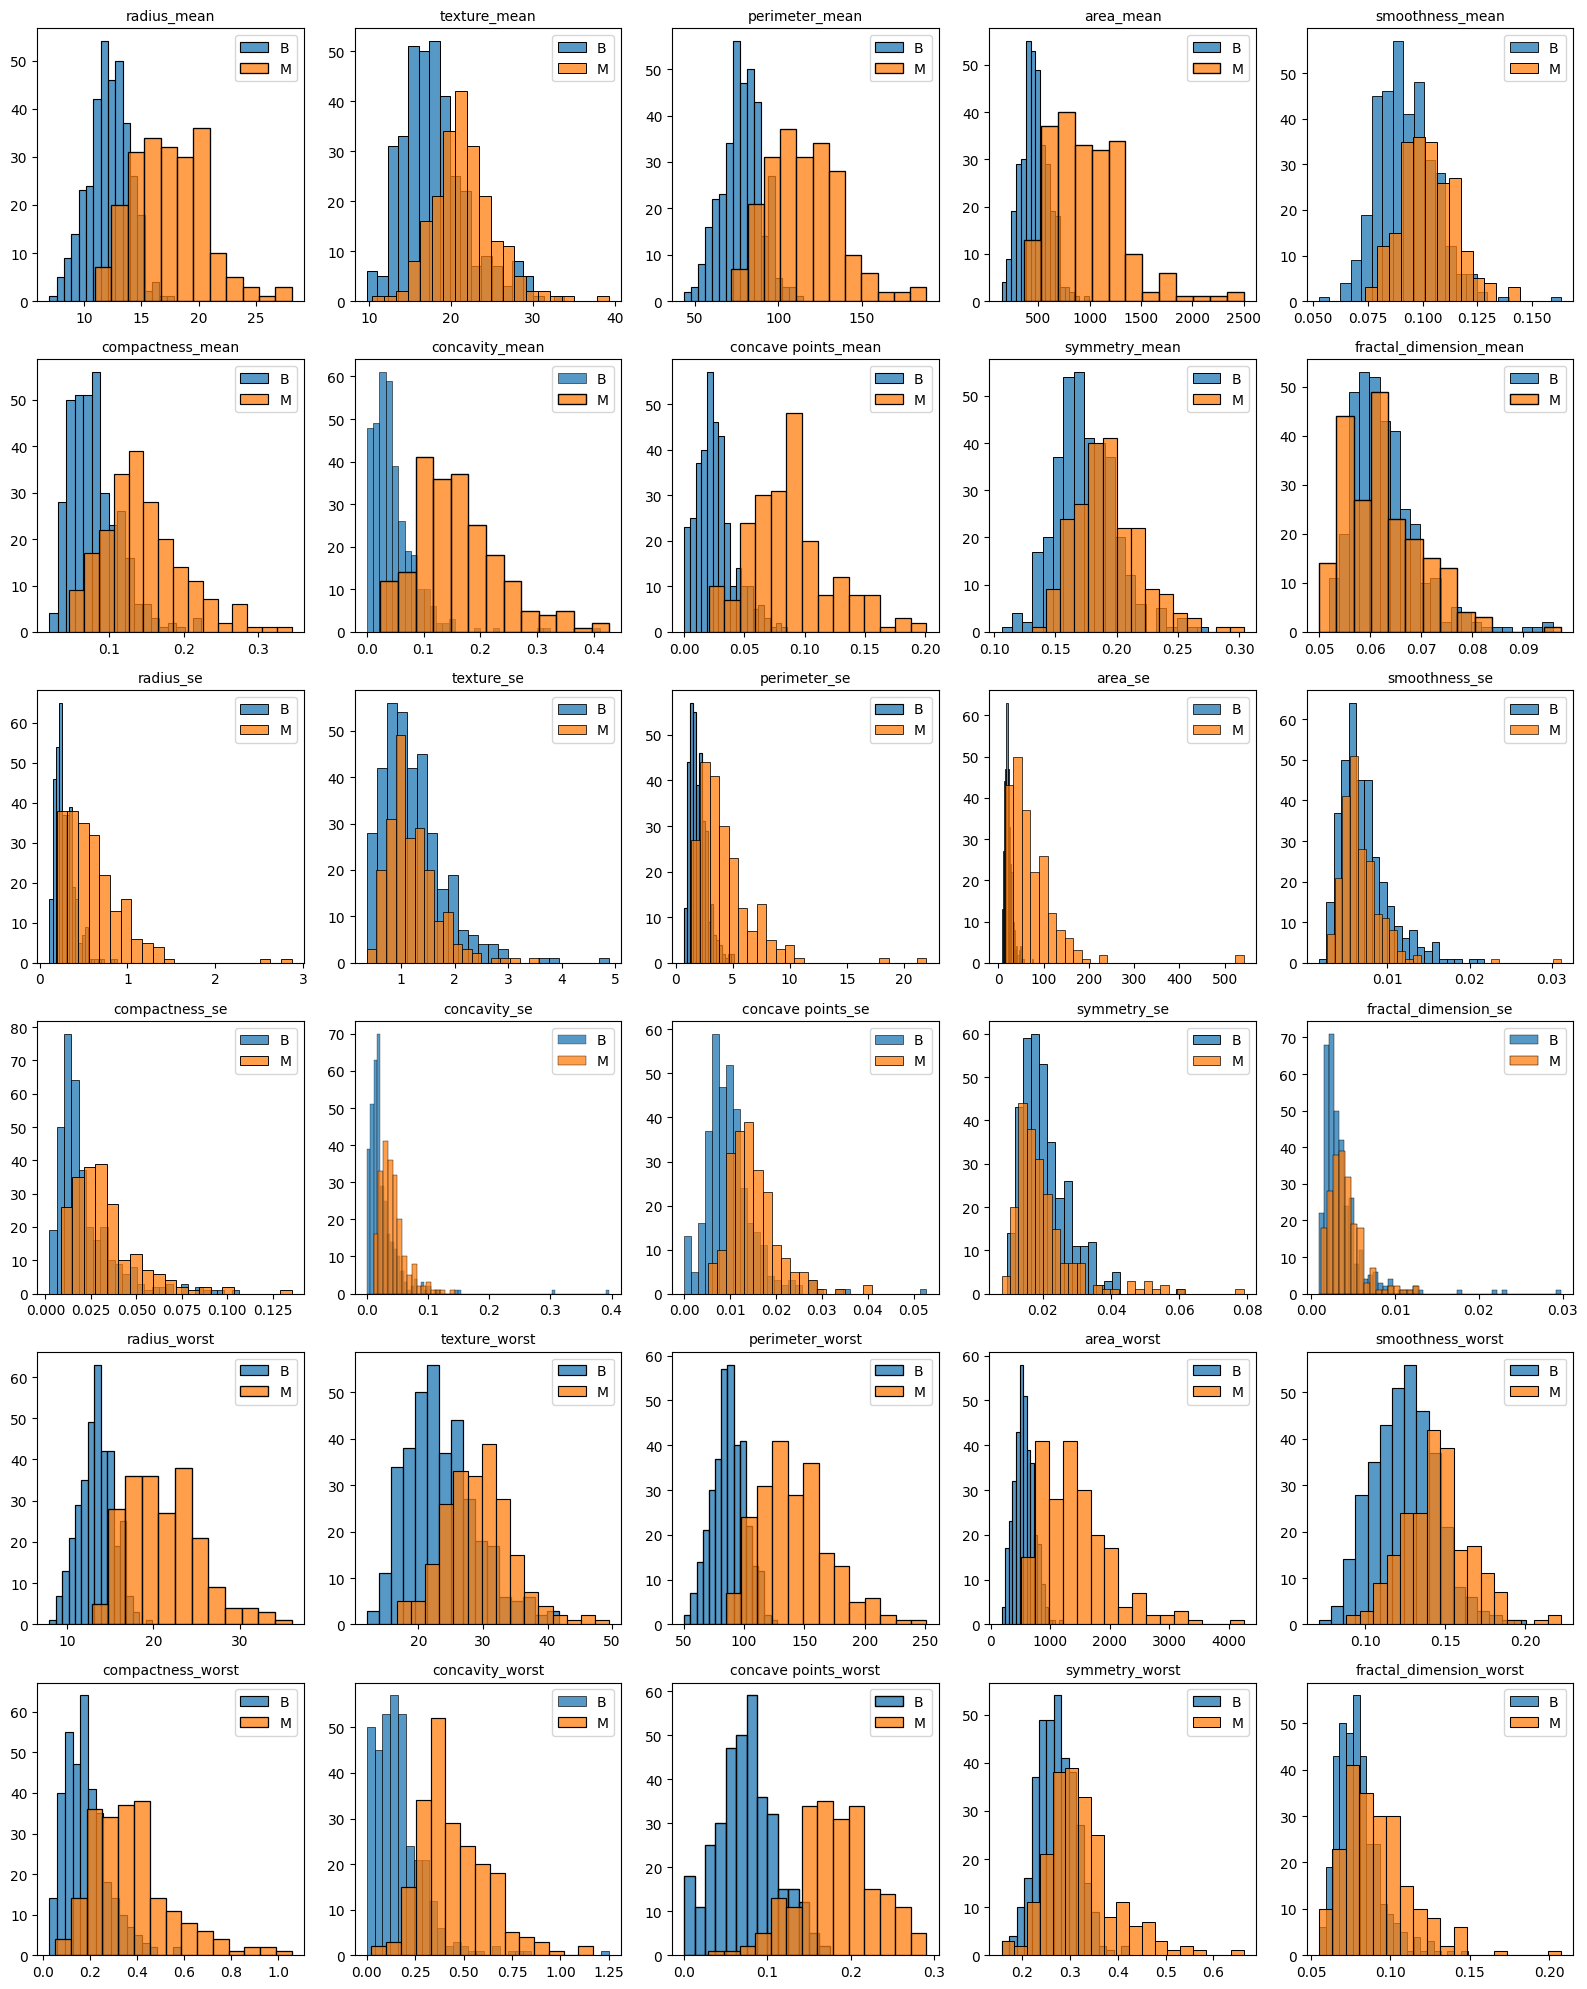

In [10]:
numeric_data = data.drop(columns=['id', 'diagnosis'])
plt.figure(figsize=(16, 20))

for indx, feature in enumerate(numeric_data.columns, 1):
    plt.subplot(6, 5, indx)
    
    b_subset = numeric_data.loc[data['diagnosis'] == 'B', feature]
    m_subset = numeric_data.loc[data['diagnosis'] == 'M', feature]
    
    sns.histplot(b_subset, label='B')
    sns.histplot(m_subset, label='M')
    plt.title(feature, fontsize=10)
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

plt.tight_layout()
plt.show()


**Analysis:**
In the above histograms, we have the tumor diagnosis type distributions based on features. For each feature plot, we can see benign tumors are on the left, whereas malignant tumors are moreso on the right. This immediately tells us the higher the number these features get, the more chances for the tumors to be malignant. Also, the features that have more distinctive distribution cutoff are the ones that have the most potential to be the key contributors when it comes to predicting which data points are malignant or benign. Features like radius_worst, concave_points_worst, and concavity_worst are pretty good ones

# Correlation Heatmap

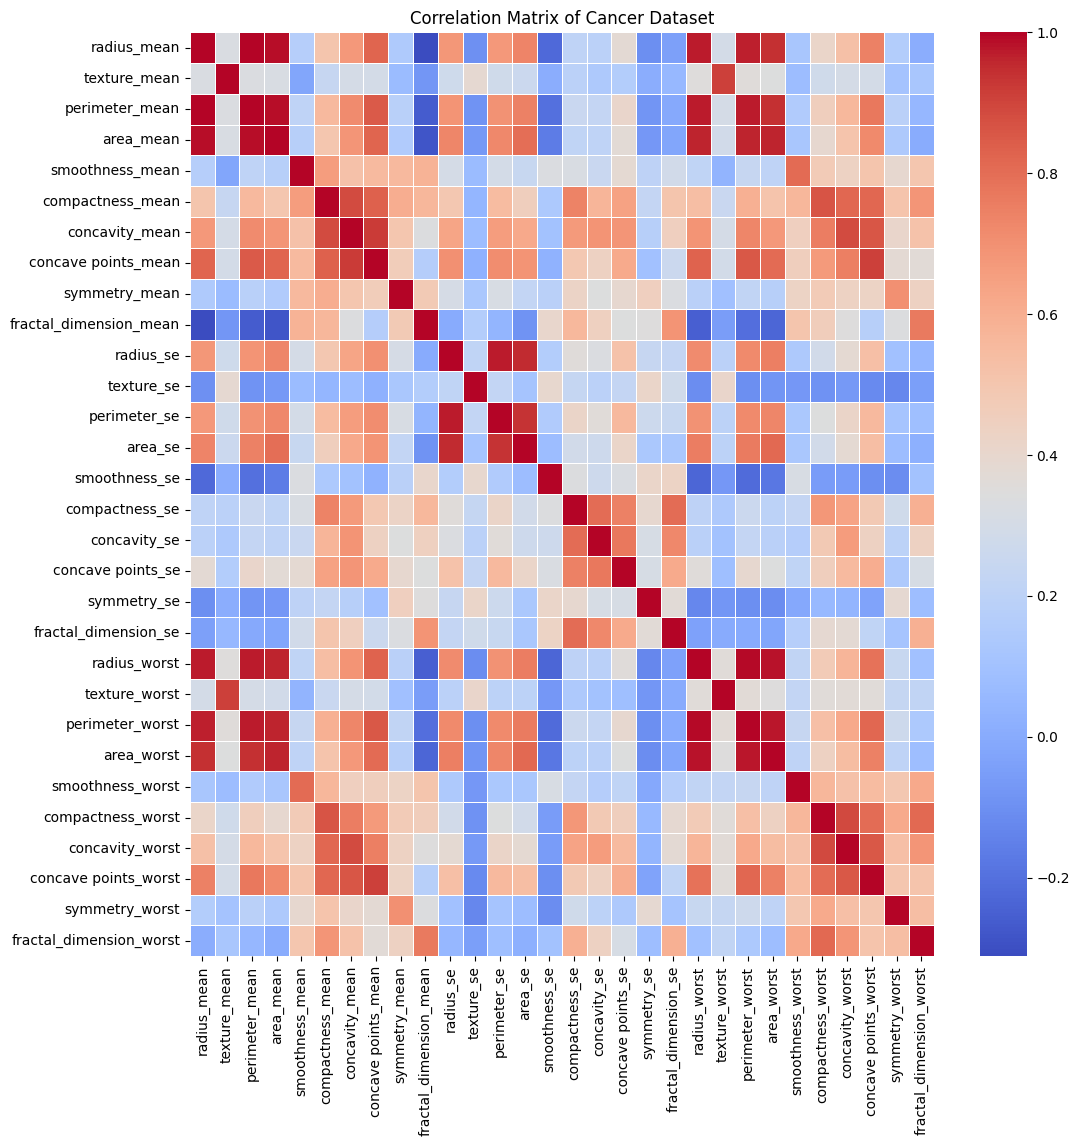

In [11]:
plt.figure(figsize=(12, 12))
sns.heatmap(numeric_data.corr(), cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Correlation Matrix of Cancer Dataset')
plt.show()

In [12]:
high_corr = numeric_data.corr().abs().unstack().sort_values(ascending=False)
high_corr = high_corr[high_corr < 1].drop_duplicates()  # Remove self-correlations
high_corr_pairs = high_corr[high_corr > 0.75]

# Display top correlated pairs
print(high_corr_pairs.head(10))

radius_mean      perimeter_mean     0.997855
perimeter_worst  radius_worst       0.993708
radius_mean      area_mean          0.987357
perimeter_mean   area_mean          0.986507
radius_worst     area_worst         0.984015
area_worst       perimeter_worst    0.977578
radius_se        perimeter_se       0.972794
perimeter_mean   perimeter_worst    0.970387
radius_mean      radius_worst       0.969539
perimeter_mean   radius_worst       0.969476
dtype: float64


**Analysis:**
In the correlation heatmap, we can see there are features that highly correlate with each other. In medical datasets like this, certain meansurements naturally correlate due to underlying biological relationships. For example, larger tumors havfe higher perimemter, area, and radius values, leading to higher correlations between these features. If features that are highly correlatede also have strong correlations with the diagnosis, then it could suggest that these measurements are important indicators for determining whether a tumor is malignant or benign.

# Encoding Diagnosis Column

By Encoding the diagnosis column, we will be able to apply machine learning models on it. We'll also explore the correlation between diagnosis and other features.

In [13]:
# We will encode diagnosis column into numeric values: 0 for benign (B) and 1 for malignant (M)
data['diagnosis'] = data['diagnosis'].map({'B': 0, 'M': 1})
data.drop(columns=['id'], inplace=True)

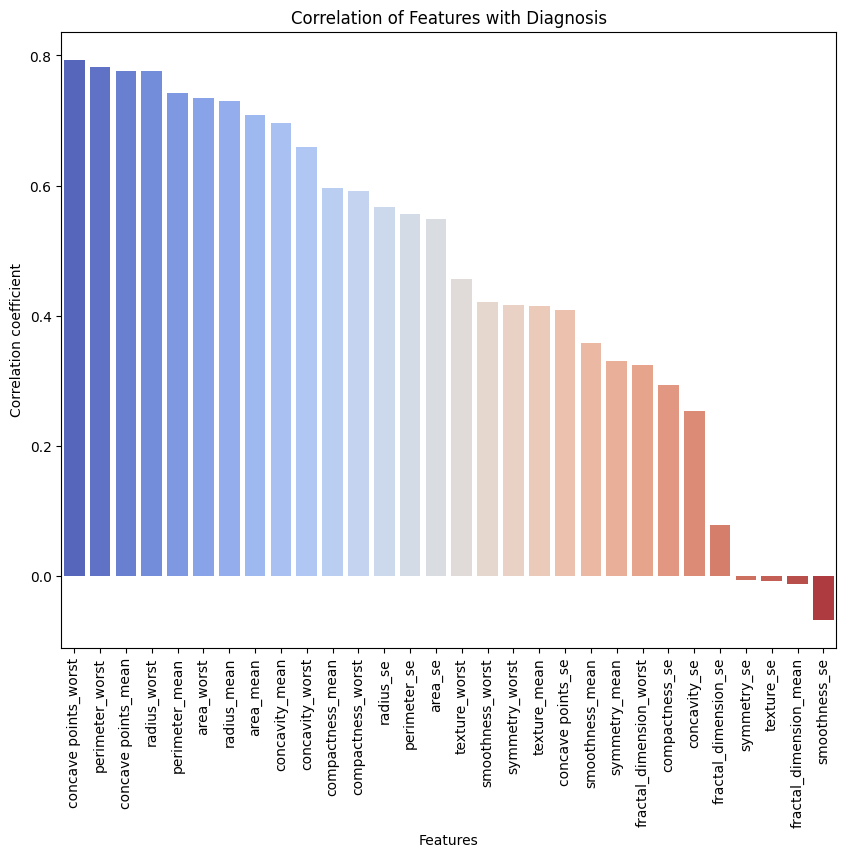

In [14]:
correlation_with_diagnosis = data.corr()['diagnosis'].drop('diagnosis').sort_values(ascending=False)

# Visualize the correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_with_diagnosis.index, y=correlation_with_diagnosis.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Correlation of Features with Diagnosis')
plt.ylabel('Correlation coefficient')
plt.xlabel('Features')
plt.show()

**Analysis:**
In the above bar graph, we've calculated the Pearson correlation between diagnosis and other numeric features. The correlation value ranges between -1 and 1. 1 means a perfect positive correlation; whereas, -1 means a perfect negative correlation. The plot shows how each of the feature correlates with diagnosis. Features with a high positive correlation are more associated with malignant tumors, while those with high negative are associated with benign tumors.

# Modeling

In [15]:
# We will first scale and standardize the features
y = data['diagnosis']
x = data.drop(columns=['diagnosis'])
scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)

# K-Means Clustering

In [16]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_x)

# Adjust labels to match the original diagnosis (0 = Benign, 1 = Malignant)
kmeans_labels_adjusted = [1 if label == 0 else 0 for label in kmeans_labels]

# Evaluate K-Means clustering accuracy
accuracy_kmeans = accuracy_score(y, kmeans_labels_adjusted)
print(f"K-Means Accuracy: {accuracy_kmeans:.3f}")

K-Means Accuracy: 0.910


# SVD + K-Means

In [17]:
# Apply SVD to reduce dimensionality
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(scaled_x)

# Apply K-Means to SVD components
kmeans_svd = KMeans(n_clusters=2, random_state=42)
kmeans_svd_labels = kmeans_svd.fit_predict(X_svd)

# Adjust labels to match the original diagnosis (0 = Benign, 1 = Malignant)
kmeans_svd_labels_adjusted = [1 if label == 0 else 0 for label in kmeans_svd_labels]

# Evaluate SVD + K-Means clustering accuracy
accuracy_svd_kmeans_2 = accuracy_score(y, kmeans_svd_labels_adjusted)
print(f"SVD + K-Means Accuracy: {accuracy_svd_kmeans_2:.3f}")

SVD + K-Means Accuracy: 0.093


In [18]:
# Apply SVD to reduce dimensionality with 5 components
svd = TruncatedSVD(n_components=5, random_state=42)
X_svd_5 = svd.fit_transform(scaled_x)

# Apply K-Means to SVD components
kmeans_svd_5 = KMeans(n_clusters=2, random_state=42)
kmeans_svd_5_labels = kmeans_svd_5.fit_predict(X_svd_5)

# Adjust labels to match the original diagnosis (0 = Benign, 1 = Malignant)
kmeans_svd_5_labels_adjusted = [1 if label == 0 else 0 for label in kmeans_svd_5_labels]

# Evaluate SVD + K-Means clustering accuracy
accuracy_svd_kmeans_5 = accuracy_score(y, kmeans_svd_5_labels_adjusted)
print(f"SVD (5 components) + K-Means Accuracy: {accuracy_svd_kmeans_5:.2f}")

SVD (5 components) + K-Means Accuracy: 0.91


In [19]:
# Create a DataFrame to compare accuracy
accuracy_comparison = pd.DataFrame({
    'Method': ['K-Means', 'SVD (2 components) + K-Means', 'SVD (5 components) + K-Means'],
    'Accuracy': [accuracy_kmeans, accuracy_svd_kmeans_2, accuracy_svd_kmeans_5]
})

print(accuracy_comparison)

                         Method  Accuracy
0                       K-Means  0.910369
1  SVD (2 components) + K-Means  0.093146
2  SVD (5 components) + K-Means  0.910369


**Analysis:**
* K-means applied on the scaled data returns the best accuracy which makes sense because scaled data ensures that all feateures contribute equally to the distance calculations in k-means. It prevents any single feature from dominating the clustering process, leading to better clustering performance. Also, k-means tends to perform well in high dimensions.
* SVD (2 components) + K-means gave a really poor result is probably due to components being too low. This simplification is too much and potentially discarded a lot of important information that distinguishes between the malignant and benign tumors. Therefore, we tried increasing the component to 5 and it gave a really good result.

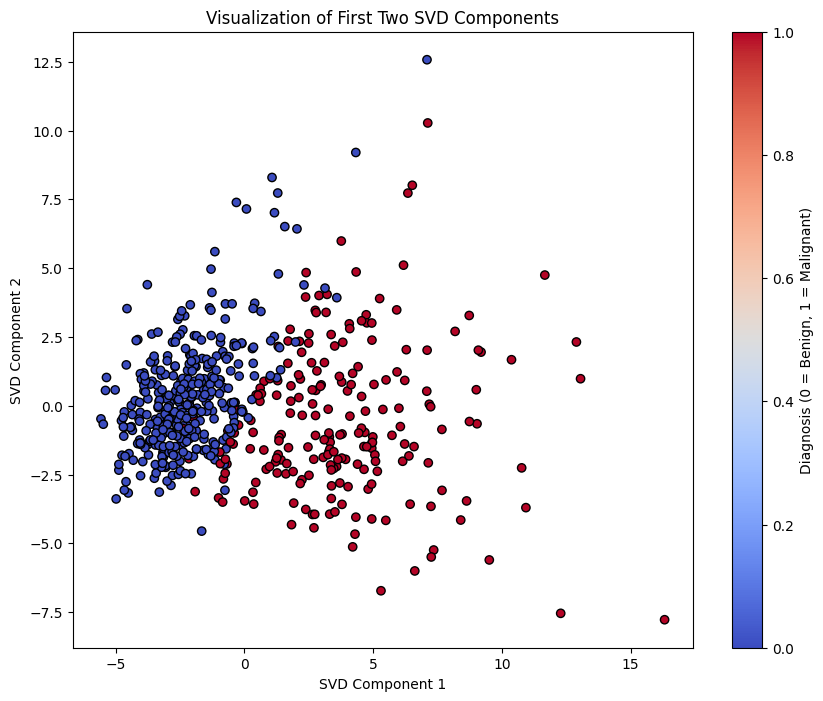

In [20]:
plt.figure(figsize=(10, 8))
plt.scatter(X_svd_5[:, 0], X_svd_5[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('Visualization of First Two SVD Components')
plt.colorbar(label='Diagnosis (0 = Benign, 1 = Malignant)')
plt.show()

**Analysis:**
By analyzing the first two components of the SVD model, we can visually asses how well these components separate the malignant and benign cases. The plot shows clear separation between different classes. This implies that the reduced-dimensional space still retains the key features necessary for distinguishing between malignant and benign cases.

# Hyperparameter Tuning via GridSearchCV

In [21]:
# Define the parameter grid for K-Means
param_grid_kmeans = {
    'n_init': [10, 20, 30],
    'max_iter': [300, 500, 1000],
    'init': ['k-means++', 'random']
}

# Custom scorer to adjust labels and calculate accuracy
def adjusted_accuracy(estimator, X, y):
    labels = estimator.fit_predict(X)
    labels_adjusted = [1 if label == 0 else 0 for label in labels]
    return accuracy_score(y, labels_adjusted)

# Grid search with accuracy as the evaluation metric
grid_search_kmeans = GridSearchCV(KMeans(n_clusters=2, random_state=42), 
                                  param_grid=param_grid_kmeans, 
                                  scoring=make_scorer(adjusted_accuracy), 
                                  cv=5)
grid_search_kmeans.fit(scaled_x, y)

# Best parameters and best score for K-Means
best_params_kmeans = grid_search_kmeans.best_params_
best_params_kmeans

{'init': 'k-means++', 'max_iter': 300, 'n_init': 10}

In [22]:
# let's apply k-means optimized params to our model
# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42, init='k-means++', max_iter=300, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_x)

# Adjust labels to match the original diagnosis (0 = Benign, 1 = Malignant)
kmeans_labels_adjusted = [1 if label == 0 else 0 for label in kmeans_labels]

# Evaluate K-Means clustering accuracy
accuracy_kmeans = accuracy_score(y, kmeans_labels_adjusted)
print(f"K-Means Accuracy: {accuracy_kmeans:.3f}")

K-Means Accuracy: 0.910


In [23]:
# Define the parameter grid for SVD + K-Means
param_grid_svd_kmeans = {
    'svd__n_components': [2, 5, 10],
    'kmeans__n_init': [10, 20, 30],
    'kmeans__max_iter': [300, 500, 1000],
    'kmeans__init': ['k-means++', 'random']
}

# Create a pipeline for SVD followed by K-Means
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('svd', TruncatedSVD(random_state=42)),
    ('kmeans', KMeans(n_clusters=2, random_state=42))
])

# Grid search with accuracy as the evaluation metric for SVD + K-Means
grid_search_svd_kmeans = GridSearchCV(pipeline, 
                                      param_grid=param_grid_svd_kmeans, 
                                      scoring=make_scorer(adjusted_accuracy), 
                                      cv=5)
grid_search_svd_kmeans.fit(scaled_x, y)

# Best parameters and best score for SVD + K-Means
best_params_svd_kmeans = grid_search_svd_kmeans.best_params_
best_params_svd_kmeans

{'kmeans__init': 'k-means++',
 'kmeans__max_iter': 300,
 'kmeans__n_init': 10,
 'svd__n_components': 2}

In [24]:
# let's apply k-means + SVD optimized params to our model
# Apply SVD to reduce dimensionality with 5 components
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd_5 = svd.fit_transform(scaled_x)

# Apply K-Means to SVD components
kmeans_svd_5 = KMeans(n_clusters=2, random_state=42, init='k-means++', max_iter=300, n_init=10)
kmeans_svd_5_labels = kmeans_svd_5.fit_predict(X_svd_5)

# Adjust labels to match the original diagnosis (0 = Benign, 1 = Malignant)
kmeans_svd_5_labels_adjusted = [1 if label == 0 else 0 for label in kmeans_svd_5_labels]

# Evaluate SVD + K-Means clustering accuracy
accuracy_svd_kmeans_5 = accuracy_score(y, kmeans_svd_5_labels_adjusted)
print(f"SVD (5 components) + K-Means Accuracy: {accuracy_svd_kmeans_5:.2f}")

SVD (5 components) + K-Means Accuracy: 0.09


**Analysis:**
Surprisingly, hyper-parameter tuning actually didn't increase the accuracy score, so this means that the scores from before were already optimized.

# Logistic Regression

In [25]:
# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Penalty type
    'solver': ['saga'],  # Saga is a solver that supports l1, l2, elasticnet, and none
    'max_iter': [100, 500, 1000]  # Maximum number of iterations
}

# Instantiate a Logistic Regression model
lr = LogisticRegression(random_state=42)

# Grid search with accuracy as the evaluation metric
grid_search_lr = GridSearchCV(lr, param_grid=param_grid_lr, scoring='accuracy', cv=5)
grid_search_lr.fit(scaled_x, y)

# Best parameters and best score for Logistic Regression
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

best_params_lr, best_score_lr

({'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'},
 0.9789318428815402)

# Conclusion

*  K-means + SVD did not outperform the standard K-means might indicate that the original high-dimensional space may have already been optimal for clustering with K-means. Also, it could mean that the clusters in the reduced space retained a smaller structure to the original space.
* The significantly higher accuracy of Logistic Regression suggests that the supervised model is more effective at distinguishing between malignant and benign cases.
* LR is designed to directly use labeled data to predict the probability of a data point belonging to a particular class, so it's not too surprsing that it performed the best out of the three.
* Some ideas for improvement could be trying other unsupervised techniques such as PCA. PCA might be able to capture more meaningful components that could improve clustering or classification performance.
* For supervised, we could try random forest due to its versatility and powerful ensemble method that can capture non-linear relationships between features.